# TUH_EEG annotation code

In [1]:
import eeglibrary
import pyedflib
import numpy as np
from pathlib import Path

In [85]:
DATA_DIR = Path('../input/')
SAVE_DIR = DATA_DIR / 'labeled_data'
SAVE_DIR.mkdir(exist_ok=True)

In [86]:
target_dir = DATA_DIR / '009/00000906/s005_2003_04_27'
label_path = target_dir / '00000906_s005_t000.tse_bi'
edf_path = target_dir / '00000906_s005_t000.edf'

In [4]:
with open(label_path, 'r') as f:
    label_info = f.read()
print(label_info)

version = tse_v1.0.0

0.0000 21.0550 bckg 1.0000
21.0550 53.3450 seiz 1.0000
53.3450 600.0000 bckg 1.0000



In [5]:
print(edf_path)
edfreader = pyedflib.EdfReader(str(edf_path))

/home/tomoya/workspace/research/brain/epilepsy/input/009/00000906/s005_2003_04_27/00000906_s005_t000.edf


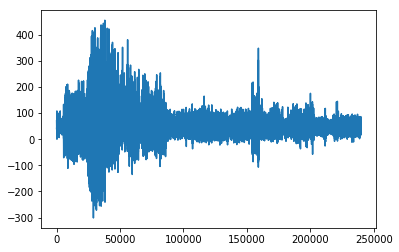

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(edfreader.readSignal(2))

In [8]:
n = edfreader.signals_in_file
signal_labels = edfreader.getSignalLabels()
sigbufs = np.zeros((n, edfreader.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = edfreader.readSignal(i)

In [47]:
signal_labels

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG EKG-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'EEG SP1-REF',
 'EEG SP2-REF',
 'EEG LUC-REF',
 'EEG RLC-REF',
 'EEG RESP1-REF',
 'EEG RESP2-REF',
 'EEG 31-REF',
 'EEG 32-REF']

In [48]:
type(sigbufs)

numpy.ndarray

In [11]:
dir(edfreader)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close',
 '_convert_string',
 '_get_float',
 'admincode',
 'annotations_in_file',
 'birthdate',
 'check_open_ok',
 'datarecord_duration',
 'datarecords_in_file',
 'digital_max',
 'digital_min',
 'equipment',
 'file_duration',
 'file_info',
 'file_info_long',
 'file_name',
 'gender',
 'getAdmincode',
 'getBirthdate',
 'getDigitalMaximum',
 'getDigitalMinimum',
 'getEquipment',
 'getFileDuration',
 'getGender',
 'getHeader',
 'getLabel',
 'getNSamples',
 'getPatientAdditional',
 'getPatientCode',
 'getPatientName',
 'getPhysicalDimension',
 'getPhysicalMaximum',
 'get

In [131]:
pat_id = edfreader.patient.decode().split()[0]
print(pat_id)
edfreader.patient.decode()
# edfreader.getFileDuration()

00000906


600

### TUH_EEG Infomation
- Sample rate: 400 Hz
- One edf file length: 600 sec
- Total signals: 240000
- labeled by time [sec]

In [35]:
label_classes = """NULL
SPSW
GPED
PLED
EYBL
ARTF
BCKG
SEIZ
FNSZ
GNSZ
SPSZ
CPSZ
ABSZ
TNSZ
CNSZ
TCSZ
ATSZ
MYSZ
NESZ
INTR
SLOW
EYEM
CHEW
SHIV
MUSC
ELPP
ELST""".lower().split('\n')
print(label_classes)

['null', 'spsw', 'gped', 'pled', 'eybl', 'artf', 'bckg', 'seiz', 'fnsz', 'gnsz', 'spsz', 'cpsz', 'absz', 'tnsz', 'cnsz', 'tcsz', 'atsz', 'mysz', 'nesz', 'intr', 'slow', 'eyem', 'chew', 'shiv', 'musc', 'elpp', 'elst']


In [83]:
sr = edfreader.getSampleFrequencies()[]
sr

400

### 10秒毎に区切っていく.
発作がある場合は、その時間を優先して区切る。
時系列データなので、連続性はとても大事。
2種類のデータを用意する
- 発作やBKGのラベルは10秒間必ず入っているものとする。発作間欠期も同様。
- 単純に10秒ごとに分割し、5秒以上発作が入っているものを発作のラベル、5秒以上BKGが入っているものをBKGのラベル、という付け方
- durationを10から変えてみる
- 他の特徴量も使用する。年齢と性別、できれば平均心拍も

#### 発作やBKGのラベルは10秒間必ず入っているものとする。発作間欠期も同様。

In [103]:
sigbufs.shape

(32, 240000)

In [108]:
duration = 10
mask = np.ones(sigbufs.shape, dtype=bool)

# 発作がある場合
for info in label_info.split('\n')[2:-1]:
    start, end, label, _ = info.split()
    mask[:, int(float(start)*sr):int(float(end)*sr)] = False
    # 10秒分切り出す。足りなければ保存しない
    for start_sec in np.arange(float(start), float(end), duration):
        if start_sec + duration > float(end):
            break
        start_idx, end_idx = int(start_sec*sr), int((start_sec+duration)*sr)
        signals = sigbufs[:, start_idx:end_idx]
        
        # ファイルに保存
        filename = '{}_{}_{}_{}_{}.npy'.format(pat_id, target_dir.name, start_idx, end_idx, label)
        np.save(SAVE_DIR / filename, signals)
    print(start, end, label)
    
# 発作以外の区間
for info in label_info.split('\n')[2:-1]:
    start, end, label, _ = info.split()
    
    # start以前と
    for start_sec in np.arange(float(start), float(end), duration):
        if start_sec + duration > float(end):
            break
        start_idx, end_idx = int(start_sec*sr), int((start_sec+duration)*sr)
        signals = sigbufs[:, start_idx:end_idx]
        
        # ファイルに保存
        filename = '{}_{}_{}_{}_{}.npy'.format(pat_id, target_dir.name, start_idx, end_idx, label)
#         np.save(SAVE_DIR / filename, signals)
    print(start, end, label)


0.0000 21.0550 bckg
21.0550 53.3450 seiz
53.3450 600.0000 bckg
0.0000 21.0550 bckg
21.0550 53.3450 seiz
53.3450 600.0000 bckg


In [109]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

#### 単純に10秒ごとに分割し、5秒以上発作が入っているものを発作のラベル、5秒以上BKGが入っているものをBKGのラベル、という付け方

<img src="IMG_0268.PNG">

In [124]:
# label_info = [info.split()[:-1] for info in label_info.split('\n')[2:-1]]
label_info = [(float(start), float(end), label) for start, end, label in label_info]


In [126]:
label_info

[(0.0, 21.055, 'bckg'), (21.055, 53.345, 'seiz'), (53.345, 600.0, 'bckg')]

In [130]:
# label_info_list = [info.split() for info in label_info.split('\n')[2:-1]]
for s_sec in np.arange(0, 400, 10):
    
    true_label = 'null'
    for info in label_info:
        start, end, label = info
        # true_labelを決定する。半分以上の時間を占めているラベルとする
        if s_sec >= start and s_sec+10 <= end:
            true_label = label
        elif s_sec >= start and s_sec+10 >= end and end - s_sec >= 5:
            true_label = label
        elif s_sec <= start and s_sec+10 <= end and s_sec+10 - start >= 5:
            true_label = label
        elif s_sec <= start and s_sec+10 >= end and end - start >= 5:
            true_label = label
    print(s_sec, s_sec+10, true_label)
    # ファイルに保存
#     filename = '{}_{}_{}_{}_{}.npy'.format(pat_id, target_dir.name, start_idx, end_idx, label)
#     np.save(SAVE_DIR / filename, sigbufs[s_sec*sr:(s_sec+10)*sr])

0 10 bckg
10 20 bckg
20 30 seiz
30 40 seiz
40 50 seiz
50 60 bckg
60 70 bckg
70 80 bckg
80 90 bckg
90 100 bckg
100 110 bckg
110 120 bckg
120 130 bckg
130 140 bckg
140 150 bckg
150 160 bckg
160 170 bckg
170 180 bckg
180 190 bckg
190 200 bckg
200 210 bckg
210 220 bckg
220 230 bckg
230 240 bckg
240 250 bckg
250 260 bckg
260 270 bckg
270 280 bckg
280 290 bckg
290 300 bckg
300 310 bckg
310 320 bckg
320 330 bckg
330 340 bckg
340 350 bckg
350 360 bckg
360 370 bckg
370 380 bckg
380 390 bckg
390 400 bckg
